In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read in the cleaned audio features file as a pandas dataframe

audio_features = pd.read_csv('audio_features.csv', index_col='track_id')
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [3]:
# scale tempo using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

audio_features.tempo = MinMaxScaler().fit_transform(audio_features.tempo.values.reshape(-1,1))
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072


Now I implement the DBSCAN algorithm.

In [4]:
def update_cluster(X, p, eps, minpts, labels, C):
    
    # initialize neighbors and index array
    n = X.shape[0]
    neighbors = []
    n_idx = []
    
    # find all neighbour points and their indices based on euclidean distance and eps
    for i in range(n):
        if (np.linalg.norm(X[p]-X[i]) < eps):
            neighbors.append(X[i])
            n_idx.append(i)
            
    # check for noise, or outliers
    if (len(neighbors) < minpts):
        for i in range(len(labels)):
            if i in n_idx:
                labels[i] = -1
    
    # assign neighbor points to cluster C
    else:
        for i in range(len(labels)):
            if i in n_idx:
                labels[i] = C
    return labels

def my_dbscan(X, eps, minpts):
    
    # initialize label array and cluster C
    n = X.shape[0]
    # all labels are initially 0
    labels = [0] * n
    C = 1
    
    # iterate through dataset and update cluster and labels
    for p in range(n):
        if labels[p] == 0:
            labels = update_cluster(X, p, eps, minpts, labels, C)
            
            # move on to the next cluster
            C += 1
        
    return labels

# partial source: https://medium.com/@darkprogrammerpb/dbscan-clustering-from-scratch-199c0d8e8da1
# full reference in bibliography

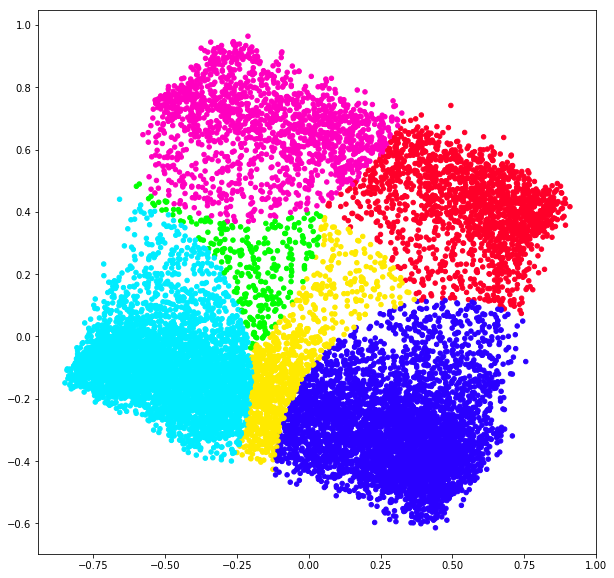

In [5]:
# apply PCA on dataset to reduce the number of dimensions to 2 for visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(audio_features)

# apply DBSCAN algorithm on dataset and visualize the clusters formed

labels = my_dbscan(X, 0.6, 50)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=labels, cmap='gist_rainbow')
plt.show()

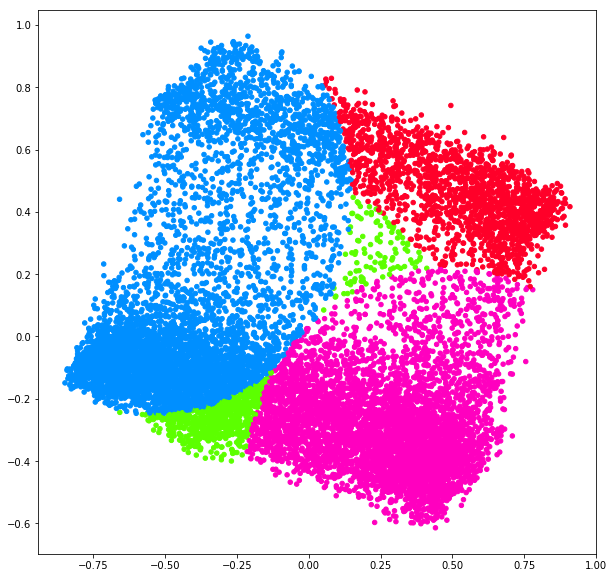

In [6]:
# for comparison, run DBSCAN with eps = 0.7

comp_labels = my_dbscan(X, 0.7, 50)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=comp_labels, cmap='gist_rainbow')
plt.show()

In [7]:
# evaluate original clustering results using scikit-learn metrics module

from sklearn import metrics

metrics.silhouette_score(X, labels, metric='euclidean')

0.3744783226478377

In [8]:
# add cluster labels to dataframe

tracks = audio_features.copy()
tracks['dbscan_label'] = labels
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,dbscan_label
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,1
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,1
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,1
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,2
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,1


In [9]:
# take a look at cluster sizes

tracks.groupby('dbscan_label').size()

dbscan_label
1    1730
2     984
3     285
4    4054
5    4498
6    1578
dtype: int64

In [10]:
# create separate dataframes for each cluster for further analysis

cluster_1 = tracks.loc[(tracks['dbscan_label'] == 1)]
cluster_1 = cluster_1.drop(columns = ['dbscan_label'])
cluster_2 = tracks.loc[(tracks['dbscan_label'] == 2)]
cluster_2 = cluster_2.drop(columns = ['dbscan_label'])
cluster_3 = tracks.loc[(tracks['dbscan_label'] == 3)]
cluster_3 = cluster_3.drop(columns = ['dbscan_label'])
cluster_4 = tracks.loc[(tracks['dbscan_label'] == 4)]
cluster_4 = cluster_4.drop(columns = ['dbscan_label'])
cluster_5 = tracks.loc[(tracks['dbscan_label'] == 5)]
cluster_5 = cluster_5.drop(columns = ['dbscan_label'])
cluster_6 = tracks.loc[(tracks['dbscan_label'] == 6)]
cluster_6 = cluster_6.drop(columns = ['dbscan_label'])

In [11]:
# create arrays of average values for each audio feature

avg_c1 = cluster_1.mean().values
avg_c2 = cluster_2.mean().values
avg_c3 = cluster_3.mean().values
avg_c4 = cluster_4.mean().values
avg_c5 = cluster_5.mean().values
avg_c6 = cluster_6.mean().values

In [12]:
# take a look at the clusters formed

data = np.array([avg_c1, avg_c2, avg_c3, avg_c4, avg_c5, avg_c6])
audio_feat_list = audio_features.columns.tolist()
clusters = pd.DataFrame(data, columns=audio_feat_list)
clusters

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,0.160041,0.536779,0.685079,0.061798,0.198633,0.117909,0.471461,0.543853
1,0.617711,0.493630,0.615650,0.772678,0.179916,0.089115,0.473134,0.489095
2,0.819112,0.499963,0.511656,0.498187,0.204658,0.113023,0.462967,0.504809
3,0.911602,0.412219,0.365232,0.883385,0.189006,0.074976,0.441604,0.345085
4,0.167478,0.523938,0.688279,0.826503,0.177068,0.085108,0.485443,0.457009
5,0.837470,0.515196,0.344551,0.064344,0.205318,0.184668,0.437896,0.477195


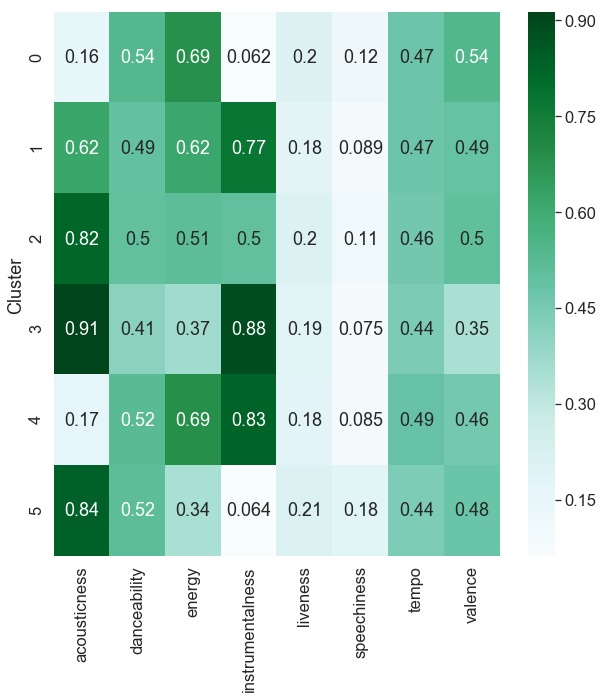

In [13]:
# visualize clusters in the form of a heatmap

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(data=clusters,cmap='BuGn',annot=True)
plt.ylabel('Cluster')
plt.show()

In [14]:
# read in the cleaned tracks with genre labels

track_genres = pd.read_csv('merged.csv', index_col='track_id')
track_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,genres,genres_all
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,[21],[21]
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,[21],[21]
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,[21],[21]
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop,[10],[10]
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,[21],[21]


In [15]:
# take a look at the genres and their counts

track_genres.groupby('genre_top').size()

genre_top
Blues                   206
Classical               387
Electronic             3187
Experimental             17
Folk                   1100
Hip-Hop                 937
Indie-Rock               69
Instrumental             84
International           398
Jazz                    547
Metal                    12
Old-Time / Historic     412
Pop                    1399
Post-Rock                 9
Psych-Folk               88
Psych-Rock               37
Punk                     16
Rock                   4149
Soundtrack               51
Trip-Hop                 24
dtype: int64

In [16]:
# find the mean audio features for each genre to merge similar ones

groups = track_genres.groupby('genre_top').agg('mean')
groups

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
genre_top,,,,,,,,
Blues,0.679041,0.498965,0.408592,0.467555,0.218809,0.077433,116.388539,0.485727
Classical,0.951297,0.346107,0.111337,0.755342,0.216919,0.075297,104.980889,0.251539
Electronic,0.339894,0.584479,0.609174,0.741754,0.174607,0.119443,124.659457,0.435730
Experimental,0.599967,0.573539,0.430228,0.506951,0.164140,0.091255,123.640412,0.617081
Folk,0.795626,0.436294,0.310816,0.615242,0.164357,0.063113,115.879338,0.357181
Hip-Hop,0.411054,0.623019,0.564882,0.358732,0.188644,0.251283,118.597536,0.590667
Indie-Rock,0.345674,0.545685,0.612887,0.658524,0.191736,0.073038,124.932435,0.405578
Instrumental,0.689762,0.504089,0.474841,0.656352,0.203607,0.097122,116.030714,0.365909
International,0.654534,0.536636,0.505165,0.561759,0.222302,0.114847,124.585905,0.575529


In [17]:
# merge similar genres into 6 groups intuitively as well as based on audio features

track_genres = track_genres.replace(['Indie-Rock', 'Metal', 'Post-Rock', 'Psych-Rock', 'Punk'], 'Rock')
track_genres = track_genres.replace(['Trip-Hop', 'Hip-Hop'], 'Hip-Hop')
track_genres = track_genres.replace(['Classical', 'Jazz', 'Old-Time / Historic', 'Instrumental', 'Soundtrack', 'International'], 'Classical/Jazz/International')
track_genres = track_genres.replace(['Electronic', 'Experimental'], 'Electronic/Experimental')
track_genres = track_genres.replace(['Blues', 'Folk', 'Psych-Folk'], 'Blues/Folk')
track_genres.groupby('genre_top').size()

genre_top
Blues/Folk                      1394
Classical/Jazz/International    1879
Electronic/Experimental         3204
Hip-Hop                          961
Pop                             1399
Rock                            4292
dtype: int64

In [18]:
# add genre labels

tracks['genre_top'] = track_genres['genre_top'].values
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,dbscan_label,genre_top
track_id,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,1,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,1,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,1,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,2,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,1,Hip-Hop


At first glance, my DBSCAN algorithm seems to have categorized Pop and Hip-Hip accurately.

In [19]:
# find the clusters that correspond to genres, according to genre counts

tracks[['genre_top', 'dbscan_label']].groupby('genre_top').agg(lambda x:x.value_counts().index[0])

# source: https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb
# full reference in bibliography

,dbscan_label
genre_top,
Blues/Folk,4
Classical/Jazz/International,4
Electronic/Experimental,5
Hip-Hop,1
Pop,5
Rock,5


In [20]:
# find the genres that correspond to clusters, according to cluster counts

tracks[['genre_top', 'dbscan_label']].groupby('dbscan_label').agg(lambda x:x.value_counts().index[0])

# source: https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb
# full reference in bibliography

,genre_top
dbscan_label,
1,Rock
2,Rock
3,Rock
4,Rock
5,Electronic/Experimental
6,Rock


As with K-means, Rock songs have clearly skewed the clustering results due to their diverse nature. I therefore decide to perform DBSCAN once again, but this time removing all Rock songs from the dataset.

In [21]:
# remove Rock songs from dataset

track_genres2 = pd.read_csv('merged.csv', index_col='track_id')
track_genres2 = track_genres2[track_genres2['genre_top'] != 'Rock']
len(track_genres2)

8980

In [22]:
track_genres2.groupby('genre_top').size()

genre_top
Blues                   206
Classical               387
Electronic             3187
Experimental             17
Folk                   1100
Hip-Hop                 937
Indie-Rock               69
Instrumental             84
International           398
Jazz                    547
Metal                    12
Old-Time / Historic     412
Pop                    1399
Post-Rock                 9
Psych-Folk               88
Psych-Rock               37
Punk                     16
Soundtrack               51
Trip-Hop                 24
dtype: int64

In [23]:
# re-group genres

track_genres2 = track_genres2.replace(['Indie-Rock', 'Metal', 'Post-Rock', 'Psych-Rock', 'Punk'], 'Metal/Punk/Indie-Rock')
track_genres2 = track_genres2.replace(['Trip-Hop', 'Hip-Hop'], 'Hip-Hop')
track_genres2 = track_genres2.replace(['Classical', 'Jazz', 'Old-Time / Historic', 'Instrumental', 'Soundtrack', 'International'], 'Classical/Jazz/International')
track_genres2 = track_genres2.replace(['Electronic', 'Experimental'], 'Electronic/Experimental')
track_genres2 = track_genres2.replace(['Blues', 'Folk', 'Psych-Folk'], 'Blues/Folk')
track_genres2.groupby('genre_top').size()

genre_top
Blues/Folk                      1394
Classical/Jazz/International    1879
Electronic/Experimental         3204
Hip-Hop                          961
Metal/Punk/Indie-Rock            143
Pop                             1399
dtype: int64

In [24]:
# create audio features dataframe

audio_features2 = track_genres2.drop(columns = ['genre_top', 'genres', 'genres_all'])
audio_features2.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [25]:
# scale tempo using MinMaxScaler

audio_features2.tempo = MinMaxScaler().fit_transform(audio_features2.tempo.values.reshape(-1,1))
audio_features2.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072


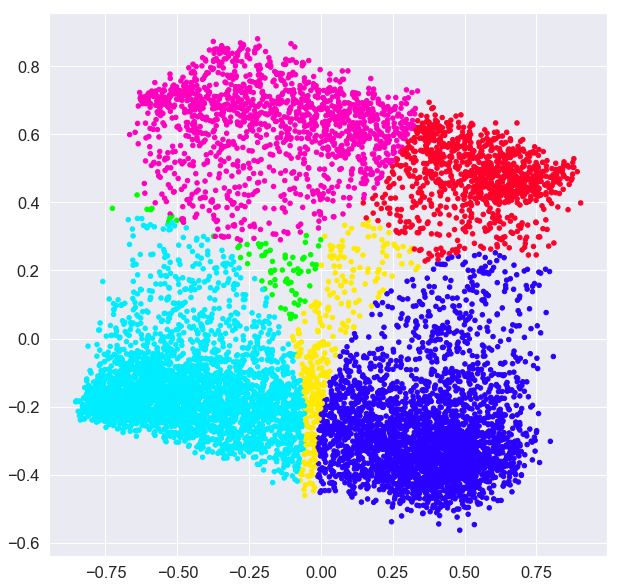

In [26]:
# apply PCA on dataset for visualization

pca = PCA(n_components=2)
X2 = pca.fit_transform(audio_features2)

# apply DBSCAN algorithm on dataset and visualize the clusters formed

labels2 = my_dbscan(X2, 0.6, 50)
plt.figure(figsize=(10,10))
plt.scatter(X2[:,0],X2[:,1], s=20, c=labels2, cmap='gist_rainbow')
plt.show()

In [27]:
# add cluster labels to dataframe

tracks2 = audio_features2.copy()
tracks2['dbscan_label'] = labels2
tracks2.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,dbscan_label
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,1
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,1
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,1
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,2
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,1


In [28]:
# add genre labels

tracks2['genre_top'] = track_genres2['genre_top'].values
tracks2.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,dbscan_label,genre_top
track_id,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,1,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,1,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,1,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,2,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,1,Hip-Hop


In [29]:
# find the clusters that correspond to genres, according to genre counts

tracks2[['genre_top', 'dbscan_label']].groupby('genre_top').agg(lambda x:x.value_counts().index[0])

# source: https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb
# full reference in bibliography

,dbscan_label
genre_top,
Blues/Folk,4
Classical/Jazz/International,4
Electronic/Experimental,5
Hip-Hop,1
Metal/Punk/Indie-Rock,5
Pop,5


In [30]:
# find the genres that correspond to clusters, according to cluster counts

tracks2[['genre_top', 'dbscan_label']].groupby('dbscan_label').agg(lambda x:x.value_counts().index[0])

# source: https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb
# full reference in bibliography

,genre_top
dbscan_label,
1,Pop
2,Electronic/Experimental
3,Pop
4,Classical/Jazz/International
5,Electronic/Experimental
6,Blues/Folk


Some genres were correctly identified, like Electronic/Experimental and Classical/Jazz/International. However, despite removing Rock songs, most genres do not seem to correspond to the clusters formed.